<a href="https://colab.research.google.com/github/sayanbanerjee32/NLP-with-fastai2.0/blob/main/fastai_on_10kGNAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# German text classification using fastai v2 and language model

Following github page has same implementation with fastai v1
https://github.com/jfilter/ulmfit-for-german

## Set up emvironment

Install required python packages

In [1]:
# !pip install fastai --upgrade
# #==2.1.4
# !pip install bpemb
# !pip install cleantext 

Download data from github

In [2]:
# !wget https://github.com/tblock/10kGNAD/raw/master/train.csv
# !wget https://github.com/tblock/10kGNAD/raw/master/test.csv
# !ls

Download the pre-trained language model

In [3]:
# !wget -O models/ulmfit_for_german_jfilter.pth https://github.com/jfilter/ulmfit-for-german/releases/download/0.1.0/ulmfit_for_german_jfilter.pth
# !ls models/

Download nltk data in nltk_data folder locally.

In [4]:
# !mkdir nltk_data
# !ls

In [5]:
import nltk
# nltk.download('stopwords', download_dir='nltk_data')
nltk.data.path.append('nltk_data')
# from nltk.corpus import stopwords

## Starting of main code

Import the python libraries

In [6]:
import csv

from bpemb import BPEmb
from cleantext import clean
#from fastai.callbacks import *
#from fastai.imports import torch
from fastai.text.all import *
import pandas as pd

#torch.cuda.set_device(2)

Download sub-word tokenization vocabulary (pre-trained) for german language.

In [7]:
bpemb_de = BPEmb(lang="de", vs=25000, dim=300)

# construct the vocabulary by added a padding token with the ID 25000 (because of the bpemb_de vocab size)
voc = bpemb_de.words + ['xxpad']
#itos = dict(enumerate(voc))
#voc = Vocab(itos)

Load the training + validation and testing data and clean them

In [8]:
def load_data(filename):
    texts = []
    labels = []
    with open(filename) as csvfile:
        # follow the 10kGNAD creator's setup
        reader = csv.reader(csvfile, delimiter=';', quotechar='\'')
        for row in reader:
            labels.append(row[0])
            texts.append(row[1])
    df = pd.DataFrame({'label': labels, 'text': texts})
    #df['text'] = df['text'].apply(lambda x: bpemb_de.encode_ids_with_bos_eos(clean(x, stp_lang='german')))
                                                                                   #lang='de')))
    # lower case and extra space handling, but no stopword or stemming or number and punctuation removal
    df['text'] = df['text'].apply(lambda x: clean(x, extra_spaces=True, stopwords=False,
                                                  lowercase=True, stp_lang='german'))
    return df

df_train_valid = load_data("train.csv")

# the last 1000 training samples are used for validation
# df_train = df_train_valid.iloc[:-1000]
# df_valid = df_train_valid.iloc[-1000:]

df_test = load_data("test.csv")

In [9]:
df_train_valid.head()

,label,text
0,Sport,"21-jähriger fällt wohl bis saisonende aus. wien – rapid muss wohl bis saisonende auf offensivspieler thomas murg verzichten. der im winter aus ried gekommene 21-jährige erlitt beim 0:4-heimdebakel gegen admira wacker mödling am samstag einen teilriss des innenbandes im linken knie, wie eine magnetresonanz-untersuchung am donnerstag ergab. murg erhielt eine schiene, muss aber nicht operiert werden. dennoch steht ihm eine mehrwöchige pause bevor."
1,Kultur,"erfundene bilder zu filmen, die als verloren gelten: ""the forbidden room"" von guy maddin und evan johnson ist ein surrealer ritt durch die magischen labyrinthe des frühen kinos. wien – die filmgeschichte ist ein friedhof der verlorenen. unter den begrabenen finden sich zahllose filme, von denen nur noch mysteriös oder abenteuerlich klingende namen kursieren; und solche, über die verstreut herumliegendes sekundärmaterial aufschluss erlaubt. einer davon ist the forbidden room, ein two-reeler von 1913/14, den der arbeitswütige us-regisseur allan dwan u. a. mit dem horrordarsteller lon chaney ..."
2,Web,"der frischgekürte ceo sundar pichai setzt auf ein umgänglicheres führungsteam. die atmosphäre im silicon valley ist rau. da werden massenhaft mitarbeiter der direkten konkurrenz abgeworben, löhne mit firmenübergreifenden mauscheleien niedrig gehalten und untergebene wegen leicht verfehlter ziele vor die tür gesetzt. auch in der höchsten firmenebene werden brutale umgangsformen gepflegt: die wutausbrüche von apple-mitgründer steve jobs sind legendär, sein früherer geschäftspartner steve wozniak hätte ihn zu lebzeiten gerne als arschloch beschimpft, traute sich aber nicht. auch google-mitgrü..."
3,Wirtschaft,"putin: ""einigung, dass wir menge auf niveau von jänner halten"". moskau – die russischen ölproduzenten wollen nach den worten von präsident wladimir putin ihre förderung in diesem jahr einfrieren. im großen und ganzen wurde eine einigung erzielt, dass wir die ölproduktion auf dem niveau von jänner halten werden, sagte putin am mittwoch in moskau. russland leidet wie andere förderstaaten unter dem drastischen einbruch der ölpreise. putin will die preise durch eine begrenzte förderung im in- und ausland stabilisieren. dazu hatte russland jüngst mit saudi-arabien und anderen großen förderlände..."
4,Inland,"estland sieht den künftigen österreichischen präsidenten auch als estnischen staatsbürger. wien/tallinn/pskow – die eltern des künftigen bundespräsidenten waren 1941 aus dem von sowjets besetzten estland in das damalige deutsche reich geflohen, wo 1944 in wien sascha van der bellen zur welt kam. estnische verwandte jubelten am dienstag über dessen wahlsieg, freude herrscht auch unter politikern des landes. interesse an van der bellen gibt es auch in der russischen stadt pskow, der geburtsstadt seiner eltern. wir haben von ganzem herzen und mit der ganzen familie mitgefiebert, sagt irina st..."


Create training and validation split (20% for validation)

In [10]:
 np.random.seed(1)
 msk = np.random.rand(df_train_valid.shape[0]) < 0.2
 df_train_valid['is_valid'] = msk
 print(df_train_valid.groupby(['is_valid','label'])['text'].count())

is_valid  label        
False     Etat              480
          Inland            718
          International    1089
          Kultur            374
          Panorama         1206
          Sport             874
          Web              1209
          Wirtschaft       1012
          Wissenschaft      412
True      Etat              121
          Inland            195
          International     271
          Kultur            111
          Panorama          304
          Sport             207
          Web               300
          Wirtschaft        258
          Wissenschaft      104
Name: text, dtype: int64


## Fine tune language model

Create data block with the sub-word vocab

In [11]:
#data_lm = TextLMDataBunch.from_ids('uf_de_exp', bs=128, vocab=voc, train_ids=df_train['text'], valid_ids=df_valid['text'])
data_lm = DataBlock(
            blocks=TextBlock.from_df('text', is_lm=True, vocab = voc),
            get_x=ColReader('text'),
            splitter=RandomSplitter(0.1))

dls_lm = data_lm.dataloaders(df_train_valid) 
dls_lm.show_batch(max_n=2)

,text,text_
0,"<unk> <unk> <unk> <unk> zwei <unk> - <unk> , die ein <unk> - video <unk> <unk> . <unk> setzt auf <unk> <unk> : mit <unk> vr - <unk> <unk> vr war der <unk> konzern unter den <unk> <unk> in der sparte , <unk> will man mit einer vr - kamera punkten . die <unk> <unk> <unk> aus zwei <unk> - <unk> mit <unk> <unk> - <unk> , <unk> ein hd - video","<unk> <unk> <unk> zwei <unk> - <unk> , die ein <unk> - video <unk> <unk> . <unk> setzt auf <unk> <unk> : mit <unk> vr - <unk> <unk> vr war der <unk> konzern unter den <unk> <unk> in der sparte , <unk> will man mit einer vr - kamera punkten . die <unk> <unk> <unk> aus zwei <unk> - <unk> mit <unk> <unk> - <unk> , <unk> ein hd - video von"
1,"<unk> pass <unk> tor vor . erst später <unk> der von <unk> <unk> auf st . louis - <unk> <unk> allen <unk> und von dort ins tor <unk> <unk> <unk> und nicht <unk> <unk> . für den <unk> <unk> <unk> es sein <unk> . <unk> in der <unk> <unk> . das ist <unk> , <unk> <unk> nach dem spiel . es ist sein <unk> <unk> ( <unk> tor ) zu gehen .","pass <unk> tor vor . erst später <unk> der von <unk> <unk> auf st . louis - <unk> <unk> allen <unk> und von dort ins tor <unk> <unk> <unk> und nicht <unk> <unk> . für den <unk> <unk> <unk> es sein <unk> . <unk> in der <unk> <unk> . das ist <unk> , <unk> <unk> nach dem spiel . es ist sein <unk> <unk> ( <unk> tor ) zu gehen . es"


Update _awd_lstm_lm_config_ to match input dimension and load pre-trained language model.

In [12]:
# learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
# learn_lm.load('/mnt/data/group07/johannes/germanlm/exp_10/models/2019_ 4_14_20_48_17_552279')

config = awd_lstm_lm_config.copy()
config['n_hid'] = 1150
learn_lm = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.5, 
                                  pretrained=False, config=config,
                                metrics=[accuracy, Perplexity()]).to_fp16()

learn_lm.load('ulmfit_for_german_jfilter')

In [13]:
learn_lm.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.956040,2.852034,0.440149,17.322987,12:36


In [14]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.891137,2.840487,0.441000,17.124096,12:36
1,2.868683,2.821079,0.442335,16.794971,12:35
2,2.849156,2.801455,0.443946,16.468596,12:34
3,2.819621,2.785388,0.445376,16.206112,12:34
4,2.806046,2.772561,0.446450,15.999561,12:35
5,2.778134,2.764056,0.447683,15.864064,12:36
6,2.777427,2.757583,0.448256,15.761706,12:36
7,2.746591,2.753757,0.448711,15.701508,12:37
8,2.743471,2.752556,0.448599,15.682659,12:37
9,2.723750,2.752396,0.448736,15.680159,12:36


Save the language model

In [15]:
learn_lm.save_encoder('german_lm_finetuned')

## Text Classification

Create data block for text classification using langauge model data loader vocabulary

In [16]:
# Note the use of the langauge model vocab in the data block
data_clas = DataBlock(
    blocks=(TextBlock.from_df('text',vocab=dls_lm.vocab), CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('label'), splitter=ColSplitter())

dls_clas = data_clas.dataloaders(df_train_valid,valid_col='is_valid',
                                      seed=1, shuffle_train=True) 

dls_clas.show_batch(max_n=3)

,text,category
0,"<unk> neues <unk> <unk> seit <unk> als <unk> an <unk> <unk> <unk> . da ist es <unk> also . das erste <unk> unter der <unk> des neuen <unk> - <unk> <unk> <unk> . und sein <unk> namens <unk> <unk> <unk> nicht nur <unk> <unk> <unk> , die mit dem zu <unk> auf <unk> first <unk> <unk> <unk> <unk> <unk> <unk> , <unk> auch die <unk> von <unk> <unk> als <unk> <unk> . seit heute <unk> <unk> sein neues <unk> <unk> <unk> an <unk> <unk> – als <unk> . das <unk> gibt es <unk> für alle , die <unk> mit <unk> <unk> oder <unk> arbeiten . später <unk> es <unk> <unk> auf allen geräten laufen , auch auf dem <unk> und der <unk> . einen <unk> <unk> es nicht mehr geben – nur noch <unk> <unk> und <unk> . nach <unk> <unk> mit dem <unk> <unk> <unk> <unk> <unk> die <unk>",Web
1,"<unk> <unk> auf dem <unk> und <unk> <unk> <unk> kein <unk> , sagen <unk> <unk> und <unk> <unk> über den <unk> von <unk> . wien – <unk> ist seit <unk> in österreich . <unk> alm mit <unk> agentur super - fi und <unk> <unk> <unk> das magazin nach österreich . <unk> zehn jahre später <unk> das <unk> als <unk> <unk> und anker für <unk> mit nach eigenen angaben <unk> <unk> , <unk> zwei <unk> in der agentur <unk> und ein <unk> für das <unk> <unk> arbeiten . alm hat die <unk> <unk> und das <unk> stellt sich neu auf : mit der redaktion auf der einen seite und der agentur <unk> auf der <unk> . <unk> geht aus dem <unk> der <unk> <unk> <unk> digital <unk> , <unk> , <unk> , <unk> und <unk> <unk> und aus der <unk> der <unk> super - fi . <unk> pläne mit der neuen",Etat
2,"<unk> <unk> mit mut zu <unk> design und <unk> <unk> aus der masse heraus . es <unk> nur selten , <unk> ein neues <unk> in der redaktion <unk> , das <unk> aus der masse <unk> . <unk> es <unk> fast so , als <unk> sich die großen hersteller <unk> <unk> auf eine <unk> design - linie <unk> . um so <unk> ist es , wenn <unk> <unk> ein <unk> <unk> , das aus <unk> <unk> <unk> – vor <unk> , wenn es von <unk> <unk> kommt , der noch <unk> mit <unk> <unk> <unk> <unk> . <unk> <unk> das erste <unk> von <unk> , das all dies <unk> . das unternehmen selbst ist <unk> ein <unk> in der branche , die <unk> personen <unk> es nicht . die <unk> gründer haben <unk> <unk> jahre lang für <unk> an <unk> <unk> . für die gestaltung der <unk> <unk> mit <unk> <unk>",Web


Update config for _awd_lstm_clas_config_ to align with input dimension

In [20]:
fscore = F1Score(average='weighted')
#ls_func = CrossEntropyLossFlat()
#random_seed(32, True)
cls_config = awd_lstm_clas_config.copy()
cls_config['n_hid'] = 1150
learn_cls = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                #loss_func = ls_func,
                                pretrained=False, config=cls_config,
                                metrics=[accuracy,fscore]).to_fp16()

Load the fine tuned language model

In [21]:
learn_cls = learn_cls.load_encoder('german_lm_finetuned')

Find optimum learning rate

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.0691830962896347)

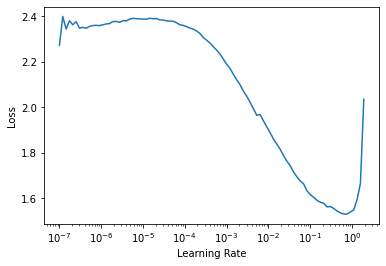

In [22]:
learn_cls.lr_find()

train the model

In [23]:
learn_cls.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.902072,0.657755,0.771780,0.771723,02:23


In [24]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.757327,0.592552,0.791555,0.791020,03:07


In [25]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.683861,0.564381,0.804917,0.804309,05:21


In [26]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.574050,0.538173,0.808658,0.808084,06:51
1,0.544561,0.537030,0.812400,0.811660,06:51


## Classification performance on test data

In [27]:
from sklearn.metrics import classification_report

In [28]:
act_class = [str(c) for c in df_test.label.values]
len(np.unique(act_class))

9

Run prediction using trained model

In [29]:
predict_df_lm = df_test.text.apply(learn_cls.predict)
#predict_df.head()
predict_df_class_lm = [x[0] for x in predict_df_lm.values]
predict_df_prob_lm = [max(x[2].tolist()) for x in predict_df_lm.values]
print(predict_df_class_lm[:10])
print(predict_df_prob_lm[:10])

['Inland', 'Sport', 'Web', 'Sport', 'International', 'Web', 'Sport', 'Panorama', 'Panorama', 'Web']
[0.44649428129196167, 0.9999762773513794, 0.9998082518577576, 0.9998757839202881, 0.9977608919143677, 0.5466559529304504, 0.9996895790100098, 0.9902164936065674, 0.5593733787536621, 0.9979398846626282]


### Classification perforamce report

In [30]:
print(classification_report(act_class, predict_df_class_lm))

               precision    recall  f1-score   support

         Etat       0.83      0.73      0.78        67
       Inland       0.74      0.77      0.76       102
International       0.87      0.77      0.81       151
       Kultur       0.80      0.83      0.82        54
     Panorama       0.73      0.77      0.75       168
        Sport       0.97      0.93      0.95       120
          Web       0.88      0.93      0.90       168
   Wirtschaft       0.76      0.78      0.77       141
 Wissenschaft       0.87      0.84      0.86        57

     accuracy                           0.82      1028
    macro avg       0.83      0.82      0.82      1028
 weighted avg       0.83      0.82      0.82      1028

